## Is it a rabbit?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U duckduckgo_search
    !pip install fastai
    !pip install fastbook

  Obtaining dependency information for duckduckgo_search from https://files.pythonhosted.org/packages/97/8e/01d4aea1f9fdac45973d2f1d07d29832a243f91106e10d8ffb442adf4f4d/duckduckgo_search-4.2-py3-none-any.whl.metadata
  Obtaining dependency information for curl-cffi>=0.5.10 from https://files.pythonhosted.org/packages/93/04/0d57a51690451437f72563031036ea4f4b529bc0cfd8e8d93487075cbe80/curl_cffi-0.5.10-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 18.2 MB/s eta 0:00:0000:01


## Step 1: Download images of rabbits and non-rabbits

In [3]:
from fastbook import *
from fastai.vision.widgets import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Searching for a rabbit photo

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('rabbit photos', max_images=1)
urls[0]

Searching for 'rabbit photos'


'https://www.simplyrabbits.com/wp-content/uploads/2020/05/What-Breeds-Are-Best-As-Pet-Rabbits-Flemish-Giant-2048x1367.jpeg'

Download a URL and take a look

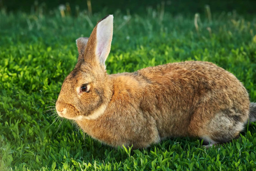

In [5]:
from fastdownload import download_url
dest = 'rabbit.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for a squirrel photo

Searching for 'squirrel photos'


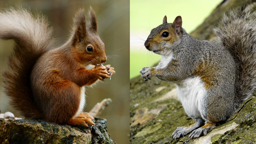

In [6]:
download_url(search_images('squirrel photos', max_images=1)[0], 'squirrel.jpg', show_progress=False)
Image.open('squirrel.jpg').to_thumb(256,256)

Search more examples of each of "rabbit" and "squirrel" photos, and save each group of photos to a different folder

In [7]:
searches = 'squirrel','rabbit'
path = Path('rabbit_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'squirrel photo'
Searching for 'squirrel sun photo'
Searching for 'squirrel shade photo'
Searching for 'rabbit photo'
Searching for 'rabbit sun photo'
Searching for 'rabbit shade photo'


## Step 2: Train our model

Remove some photos that not download correctly

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

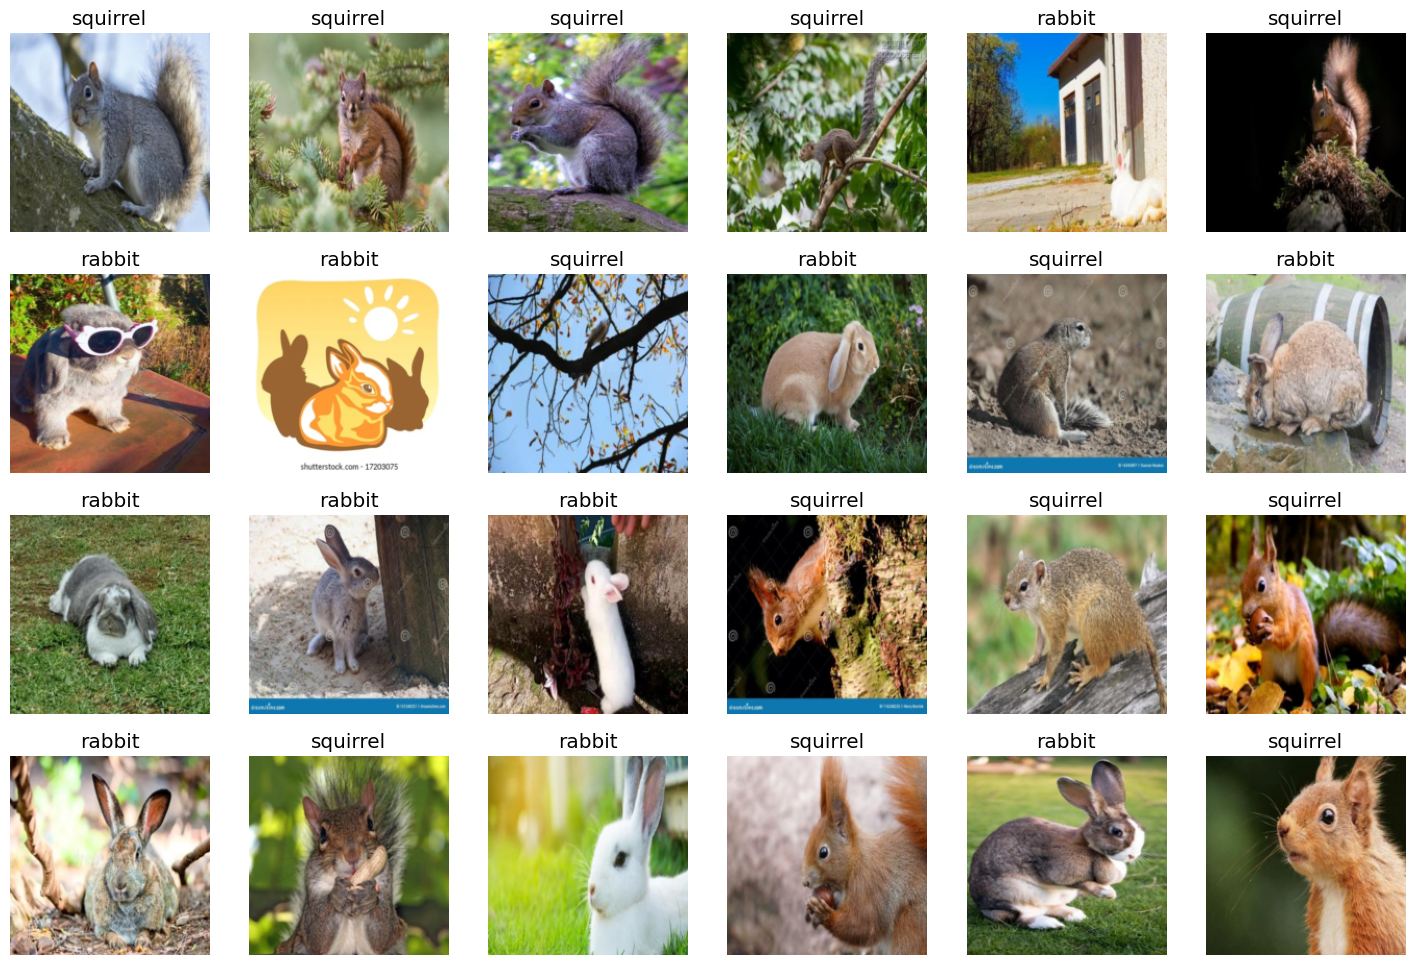

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=24)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 245MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.178536,0.932035,0.303030,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.358462,0.328399,0.121212,00:01
1,0.236027,0.185927,0.060606,00:01
2,0.168384,0.157791,0.060606,00:01


## Step 3: Use our model

In [11]:
is_rabbit,_,probs = learn.predict(PILImage.create('rabbit.jpg'))
print(f"This is a: {is_rabbit}.")
print(f"Probability it's a rabbit: {probs[0]:.4f}")

This is a: rabbit.
Probability it's a rabbit: 1.0000
